In [0]:
import torch
from torch import nn, optim
from torch.nn import functional as F
import torchvision
from torchvision.utils import save_image
import numpy as np
import os

In [2]:
 ! pip install -U -q PyDrive

     |████████████████████████████████| 993kB 2.8MB/s 


In [0]:
class CONFIG(object):
    def __init__(self):
        self.image_size = 28
        self.device = torch.device("cuda") # or "cpu"
        self.batch_size = 64
        self.num_classes = 10
        self.latten_size = 10
        self.beta = 4
        self.use_BN = True
        self.version = 'B-VAE'
        self.KL_penalty = 'abs'
        self.use_label = True
        self.C_max = 20
        self.iter_increase_C = 2e4
        self.gamma = 10
        
config = CONFIG()
assert config.version in ['VAE', 'B-VAE', 'U-VAE']
assert config.KL_penalty in ['relu', 'abs']

In [0]:
class VAE(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        # encoder
        self._conv1    = nn.Conv2d(1, 32, 4, stride=2, padding=1)
        self._conv1_BN = nn.BatchNorm2d(num_features=32)
        self._conv2    = nn.Conv2d(32, 32, 4, stride=2, padding=1)
        self._conv2_BN = nn.BatchNorm2d(num_features=32)
        self._conv3    = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self._conv3_BN = nn.BatchNorm2d(num_features=64)
        self._conv4    = nn.Conv2d(64, 128, 4, stride=1, padding=0)
        self._conv4_BN = nn.BatchNorm2d(num_features=128)
        self._fc51     = nn.Linear(128, config.latten_size)
        self._fc51_BN  = nn.BatchNorm1d(num_features=config.latten_size)
        self._fc52     = nn.Linear(128, config.latten_size)

        # decoder
        if config.use_label:
            self.fc1_  = nn.Linear(config.latten_size + config.num_classes, 128)
        else:
            self.fc1_  = nn.Linear(config.latten_size, 128)
        self.fc1_BN    = nn.BatchNorm1d(num_features=128)
        self.conv2_    = nn.ConvTranspose2d(128, 64, 4, stride=1, padding=0)
        self.conv2_BN  = nn.BatchNorm2d(num_features=64)
        self.conv3_    = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1)
        self.conv3_BN  = nn.BatchNorm2d(num_features=32)
        self.conv4_    = nn.ConvTranspose2d(32, 32, 4, stride=2, padding=1)
        self.conv4_BN  = nn.BatchNorm2d(num_features=32)
        self.conv5_    = nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)
        
        
    def encode(self, x):
        h = (self._conv1(x))
        h = self._conv1_BN(h) if config.use_BN else h
        h = F.relu(h)
        
        h = (self._conv2(h))
        h = self._conv2_BN(h) if config.use_BN else h
        h = F.relu(h)
        
        h = (self._conv3(h))
        h = self._conv3_BN(h) if config.use_BN else h
        h = F.relu(h)
        
        h = (self._conv4(h))
        h = self._conv4_BN(h) if config.use_BN else h
        h = F.relu(h)
        
        h = h.view(-1, 128)
        
        mean = self._fc51(h)
        var = torch.exp(self._fc52(h))

        return mean, var
    
    
    def decode(self, z, label=None):
        if config.use_label and label is not None:
            z = torch.cat((z, label), dim=1)
        
        h = self.fc1_(z)
        h = self.fc1_BN(h) if config.use_BN else h
        h = F.relu(h)
        
        h = h.view(-1, 128, 1, 1)
        
        h = self.conv2_(h)
        h = self.conv2_BN(h) if config.use_BN else h
        h = F.relu(h)
        
        h = self.conv3_(h)
        h = self.conv3_BN(h) if config.use_BN else h
        h = F.relu(h)
        
        h = self.conv4_(h)
        h = self.conv4_BN(h) if config.use_BN else h
        h = F.relu(h)
        
        recon_x = self.conv5_(h)
        
        return recon_x
        
        
    def forward(self, x, label=None):
        mean, var = self.encode(x.view(-1, 1, config.image_size, config.image_size))
        
        # sampling using reparameterize trick
        samples = torch.randn_like(mean) # sample: Normal distribution
        z = mean + samples * torch.sqrt(var)
        
        recon_x = self.decode(z, label)

        return mean, var, recon_x

In [0]:
def compute_recon_loss(x, recon_x):
    return F.binary_cross_entropy_with_logits(recon_x, x, reduction='sum') / x.shape[0]

def compute_KL_loss(mean, var):
    KL_loss = -0.5 * torch.sum(1 + torch.log(var) - torch.pow(mean, 2) - var)
    return KL_loss / mean.shape[0]

In [6]:
mnist_dataloader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data', train=True, download=True,
                                 transform=torchvision.transforms.ToTensor()),
                                batch_size=config.batch_size, shuffle=True)

mnist_test_dataloader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data', train=False, download=True,
                                 transform=torchvision.transforms.ToTensor()),
                                batch_size=1024, shuffle=False)

# dsprites_dataloader = datasets.get_dsprites_dataloader(batch_size=config.batch_size, 
#                                                        path_to_data='data/dsprites_ndarray_64x64.npz', subsample=-1)
#                                                       #subsample=256000)

dataloader = mnist_dataloader

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 23955317.09it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 455480.47it/s]
  1%|          | 16384/1648877 [00:00<00:11, 145414.96it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 7634640.72it/s]                            
8192it [00:00, 185066.08it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
model = VAE().to(config.device)
optimizer = optim.Adam(model.parameters(), lr=5e-4)

global_iter = 0

def train(epoch):
    model.train()
    
    train_loss_accum = recon_loss_accum = 0
    global global_iter
    print(global_iter)
    
    C_max = torch.autograd.Variable(torch.cuda.FloatTensor([config.C_max]), requires_grad=False)
    
    for batch_idx, (X, Y) in enumerate(dataloader):
        # load data to GPU
        X = X.to(config.device)
        Y_onehot = (Y.reshape(-1, 1) == torch.arange(config.num_classes).reshape(1, config.num_classes)).float()
        Y_onehot = Y_onehot.to(config.device)
        
        # update iteration counter and reset gradients
        global_iter += 1
        optimizer.zero_grad()
        
        # forward
        mean, var, recon_x = model(X, Y_onehot)
        
        # compute losses
        recon_loss = compute_recon_loss(X, recon_x)
        KL_loss = compute_KL_loss(mean, var)
        
        loss = recon_loss + KL_loss
        if config.version == 'B-VAE':
            loss = recon_loss + KL_loss * config.beta
        elif config.version == 'U-VAE':
            C = torch.clamp(C_max * global_iter / config.iter_increase_C, 0, config.C_max)
            if config.KL_penalty == 'abs':
                t = config.gamma * torch.abs((KL_loss - C))
            elif config.KL_penalty == 'relu':
                t = config.gamma * F.relu((KL_loss - C))
            loss = recon_loss + t
        
        train_loss_accum += loss.item()
        recon_loss_accum += recon_loss.item()
        
        # caculate gradients
        loss.backward()
        
        # update the weights
        optimizer.step()
        
        if batch_idx % 200 == 0:
            print(recon_loss.item(), KL_loss.item())
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(X), len(dataloader.dataset),
                100. * batch_idx / len(dataloader),
                loss.item()))
            
    epoch_loss = train_loss_accum / len(dataloader.dataset) * config.batch_size
    epoch_recon_loss = recon_loss_accum / len(dataloader.dataset) * config.batch_size
    
    print('====> Epoch: {} Average loss: {:.4f} \tRecon Loss: {:.4f}'.format(epoch, epoch_loss, epoch_recon_loss))

for epoch in range(1, 151):
    train(epoch)

0
472.527587890625 0.478392630815506
Train Epoch: 1 [0/60000 (0%)]	Loss: 474.441162
183.81103515625 1.2531003952026367
Train Epoch: 1 [12800/60000 (21%)]	Loss: 188.823441
141.1861572265625 2.6181201934814453
Train Epoch: 1 [25600/60000 (43%)]	Loss: 151.658630
138.75888061523438 3.479553699493408
Train Epoch: 1 [38400/60000 (64%)]	Loss: 152.677094
129.058837890625 4.213199615478516
Train Epoch: 1 [51200/60000 (85%)]	Loss: 145.911636
====> Epoch: 1 Average loss: 176.9549 	Recon Loss: 166.6092
938
132.44949340820312 4.229634761810303
Train Epoch: 2 [0/60000 (0%)]	Loss: 149.368027
121.86892700195312 4.606262683868408
Train Epoch: 2 [12800/60000 (21%)]	Loss: 140.293976
124.5489273071289 4.835143089294434
Train Epoch: 2 [25600/60000 (43%)]	Loss: 143.889496
119.72655487060547 5.130672454833984
Train Epoch: 2 [51200/60000 (85%)]	Loss: 140.249237
====> Epoch: 2 Average loss: 143.9418 	Recon Loss: 124.6378
1876
131.26889038085938 5.147835731506348
Train Epoch: 3 [0/60000 (0%)]	Loss: 151.860229
1

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

uploaded = drive.CreateFile({'title': "model-epoch-150.pt",\
                           "parents": [{"kind": "drive#fileLink","id": '1v3f93-vq1fJo_pM008praz21dL5ZtDcv'}]})
torch.save(model, 'model.pt')
uploaded.SetContentFile('model.pt')
uploaded.Upload()

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
model.eval()


tmp = iter(dataloader)
batch_x, batch_y  = tmp.next()

output_dir = "VAE_results/dsprites/add_label/beta_{}/latten_size_{}".format(config.beta, config.latten_size)
print(output_dir)

def hidden_travel(images, label, neuron_id):
    samples = images.reshape(-1, 1, config.image_size, config.image_size).to(config.device)
    num_imgs = len(samples)
    means, var = model.encode(samples)

    result = torch.zeros((num_imgs, 22, 1, config.image_size, config.image_size))

    result[:, 0] = samples
    
    with torch.no_grad():
        for i, d in enumerate(np.linspace(-3, 3, 21)):
            means_t = torch.clone(means)
            means_t[:, neuron_id] = d
            
            samples = model.decode(means_t, label).cpu()
            samples = torch.sigmoid(samples)
            result[:, i + 1] = samples
    print(result.shape)
    save_image(result.view(-1, 1, config.image_size, config.image_size), 
               '{}/travel_neuron_{}.png'.format(output_dir, neuron_id), 
               nrow=22, pad_value=255)

VAE_results/dsprites/add_label/beta_4/latten_size_10


In [0]:
! cd VAE_results/dsprites/add_label/beta_10/latten_size_10 && rm *

In [0]:
try:
    os.makedirs(output_dir)
except Exception as e:
    print(e)

    
# with torch.no_grad():
#     samples = torch.randn(64, config.latten_size).to(config.device)
#     samples = model.decode(samples)
#     samples = torch.sigmoid(samples).cpu()
#     save_image(samples.view(64, 1, config.image_size, config.image_size),
#                '{}/samples.png'.format(output_dir), pad_value=255)
    
    
# with torch.no_grad():
#     save_image(batch_x[0:32].view(-1, 1, config.image_size, config.image_size), '{}/orgin.png'.format(output_dir), pad_value=255)
#     samples = batch_x[0:32].reshape(-1, 1, config.image_size, config.image_size).to(config.device)
#     means, var = model.encode(samples)
    
# #     mean, var, recon_x = model(samples, None)
# #     print(var)
# #     recon_x_loss, KL_loss = loss_function(samples, mean, var, recon_x)
# #     recon_x_loss /= len(samples)
# #     KL_loss /= len(samples)
# #     print(recon_x_loss.item(), KL_loss.item())
    
#     samples = model.decode(means)
#     samples = torch.sigmoid(samples).cpu()
#     save_image(samples.view(-1, 1, config.image_size, config.image_size), '{}/reconstructed.png'.format(output_dir), pad_value=255)
    
    
for neuron_id in range(0, config.latten_size):
    label = (batch_y[0:16].reshape(-1, 1) == torch.arange(config.num_classes).reshape(1, config.num_classes)).float()
        
    label = label.to(config.device)
    hidden_travel(batch_x[0:16], label, neuron_id)

[Errno 17] File exists: 'VAE_results/dsprites/add_label/beta_4/latten_size_10'
torch.Size([16, 22, 1, 28, 28])
torch.Size([16, 22, 1, 28, 28])
torch.Size([16, 22, 1, 28, 28])
torch.Size([16, 22, 1, 28, 28])
torch.Size([16, 22, 1, 28, 28])
torch.Size([16, 22, 1, 28, 28])
torch.Size([16, 22, 1, 28, 28])
torch.Size([16, 22, 1, 28, 28])
torch.Size([16, 22, 1, 28, 28])
torch.Size([16, 22, 1, 28, 28])


In [0]:
import matplotlib.pyplot as plt
import glob


auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

for f in glob.glob("{}/*.png".format(output_dir)):
    uploaded = drive.CreateFile({'title': f.split('/')[-1],  "parents": [{"kind": "drive#fileLink","id": '1v3f93-vq1fJo_pM008praz21dL5ZtDcv'}]})
    uploaded.SetContentFile(f)
    uploaded.Upload()
    print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1glUg_MrHgHfuqDcZA4Ef0DqiEMvzBFW0
Uploaded file with ID 1p4Q8NOVWFc0ylPfNS2x2IQTj7tdAkDBI
Uploaded file with ID 1lY2wCMLGijFuY3ZKS7Vp-aHXFXZ8hCXF
Uploaded file with ID 1K_ELzJrTKRsTIAF5f5Y7QW8RDvkWHNc1
Uploaded file with ID 1xrthUjXEFTMnQ9Zp0cjLLevcRR97ULNa
Uploaded file with ID 17OwJN7kQ48hhyVaYidJKnlSACAAiJdwa
Uploaded file with ID 1xH1Xebjra-AEq-I_0roFDFGstgeVun3-
Uploaded file with ID 15LIdBJkNbN5VFva64EnhcT430VcVL9jL
Uploaded file with ID 1_CVxGQEuQ-UJd5xeSoL3zaqWXsiboW1s
Uploaded file with ID 1VvRyuU7VSa0o7RMVJQk57kp1tmg5iBgJ


In [0]:
from google.colab import files
t = files.upload()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
model = torch.load('model-epoch-150.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `

In [0]:
with torch.no_grad():
    samples = torch.randn(64, config.latten_size).to(config.device)
    samples = model.decode(samples)
    samples = torch.sigmoid(samples).cpu()
    save_image(samples.view(64, 1, config.image_size, config.image_size),
               '{}/samples.png'.format(output_dir), pad_value=255)
    
    
with torch.no_grad():
    save_image(batch_x[0:32].view(-1, 1, config.image_size, config.image_size), '{}/orgin.png'.format(output_dir), pad_value=255)
    samples = batch_x[0:32].reshape(-1, 1, config.image_size, config.image_size).to(config.device)
    means, var = model.encode(samples)
    
    samples = model.decode(means)
    samples = torch.sigmoid(samples).cpu()
    save_image(samples.view(-1, 1, config.image_size, config.image_size), '{}/reconstructed.png'.format(output_dir), pad_value=255)

AttributeError: ignored

In [0]:
with torch.no_grad():
    samples = batch_x.reshape(-1, 1, config.image_size, config.image_size).to(config.device)
    means, var = model.encode(samples)

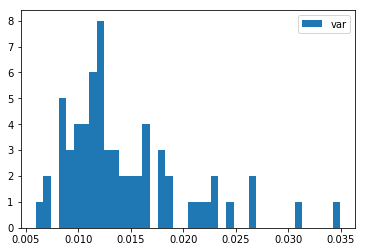

In [0]:
neuron_id = 5
mean_ = means[:, neuron_id].cpu().numpy()
var_ = var[:, neuron_id].cpu().numpy()
#plt.hist2d(mean_, var_, normed=True)
plt.hist(var_, bins=40, label='var')
#plt.hist(mean_, bins=40, label='mean')
plt.legend()

In [0]:
def compute_KL_loss(mean, var):
    KL_loss = -0.5 * torch.sum(1 + torch.log(var) - torch.pow(mean, 2) - var)
    print(mean.shape[0])
    return KL_loss / mean.shape[0]

print(means[idx:idx+1])
print(var[idx:idx+1])
compute_KL_loss(means[idx:idx+1], var[idx:idx+1])

tensor([[ 0.5299, -2.2949, -2.0698, -0.0866, -0.2464, -1.2444,  0.7510, -0.3550,
          0.0396,  0.5175]], device='cuda:0')
tensor([[0.0132, 0.0080, 0.0107, 0.0024, 0.0038, 0.0112, 0.0199, 0.0036, 0.0080,
         0.0048]], device='cuda:0')
1


tensor(26.0164, device='cuda:0')

# New Section

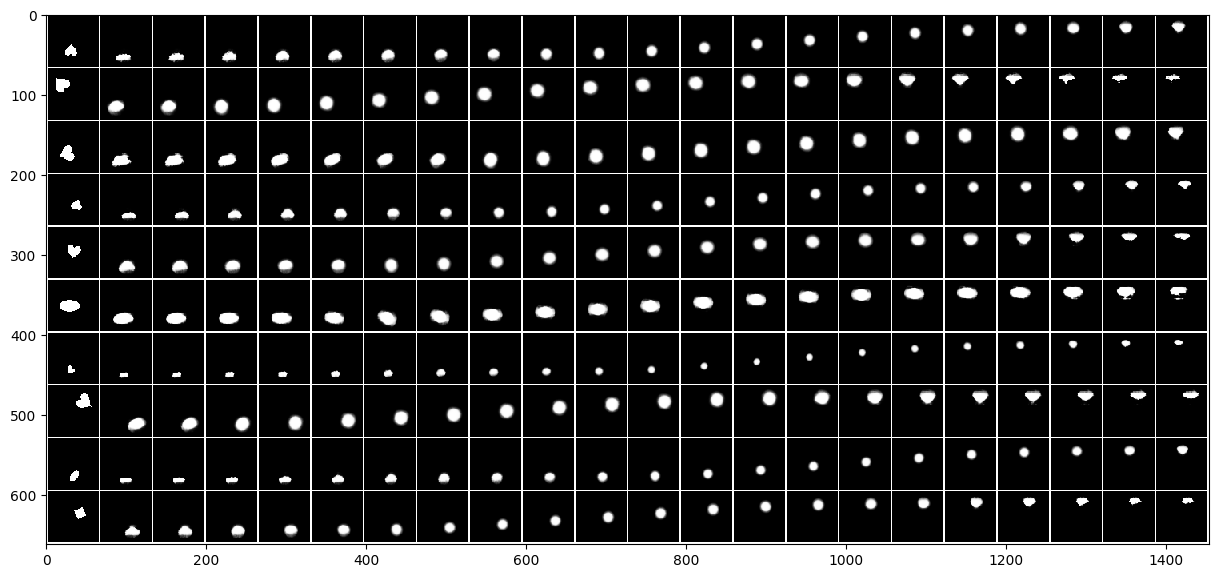

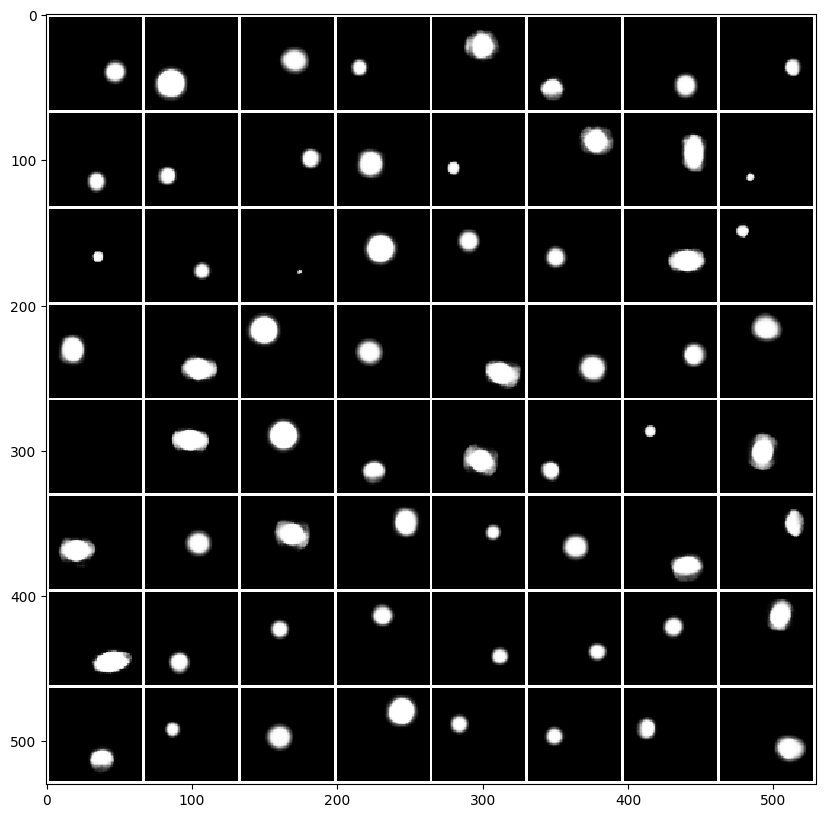

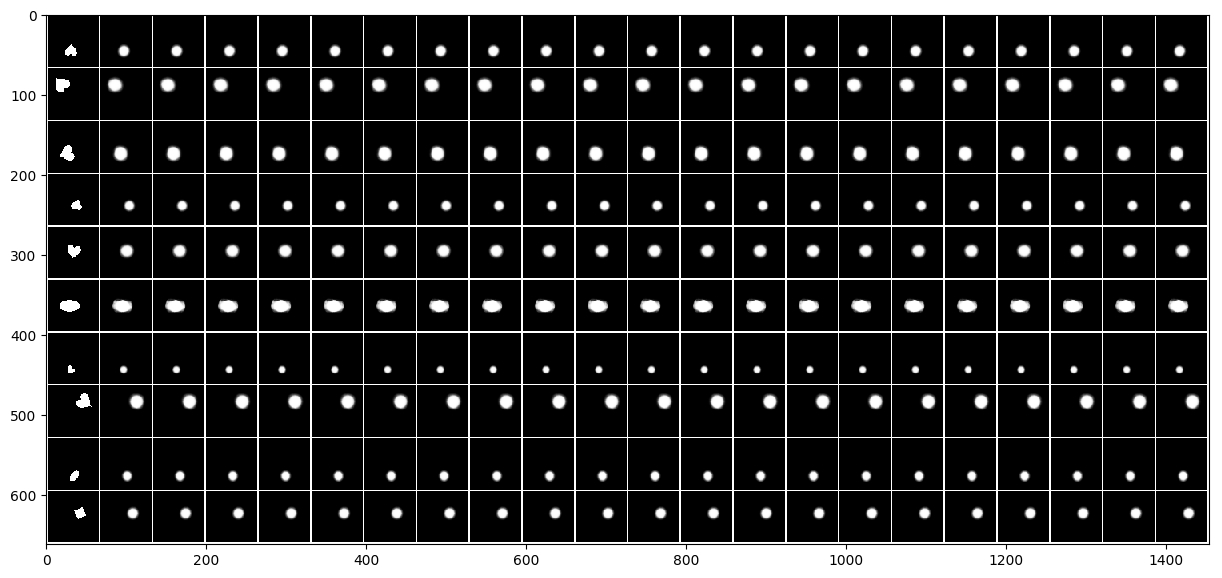

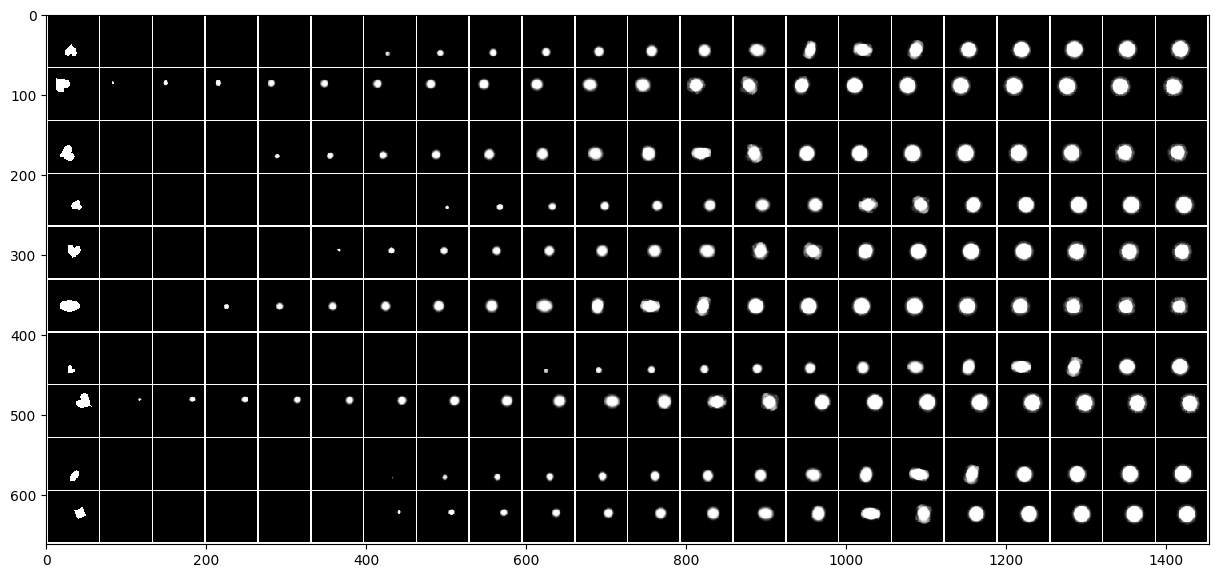

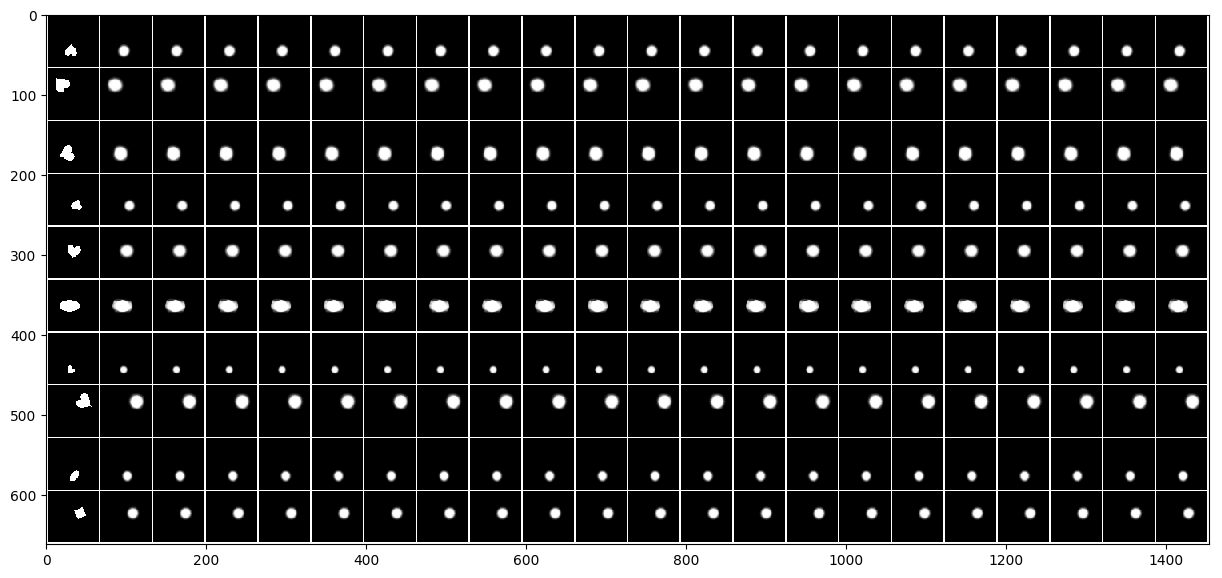

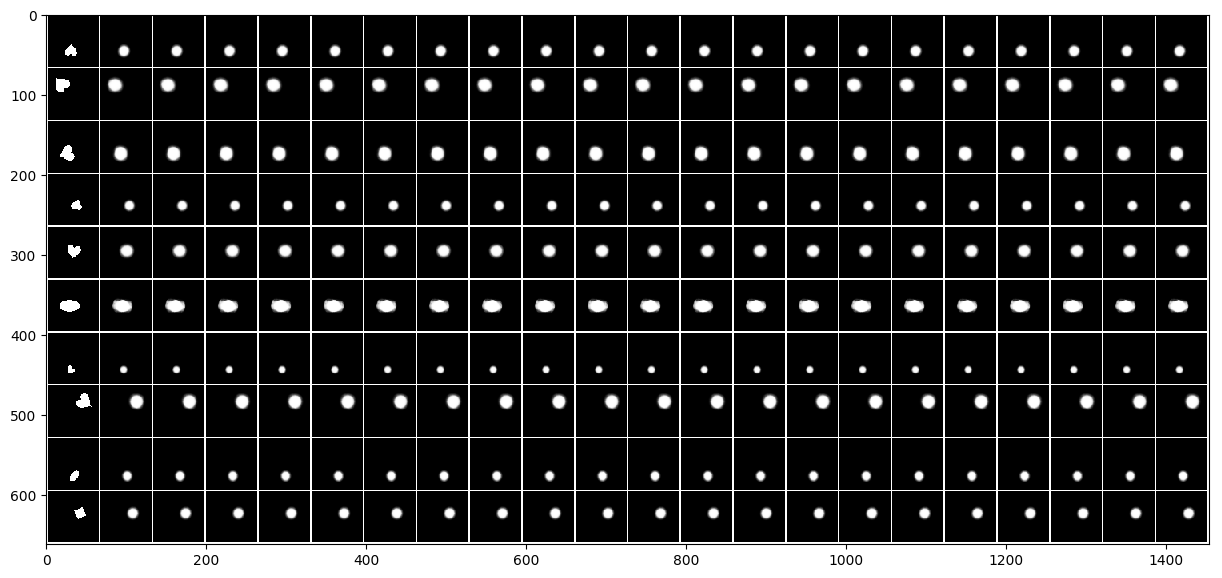

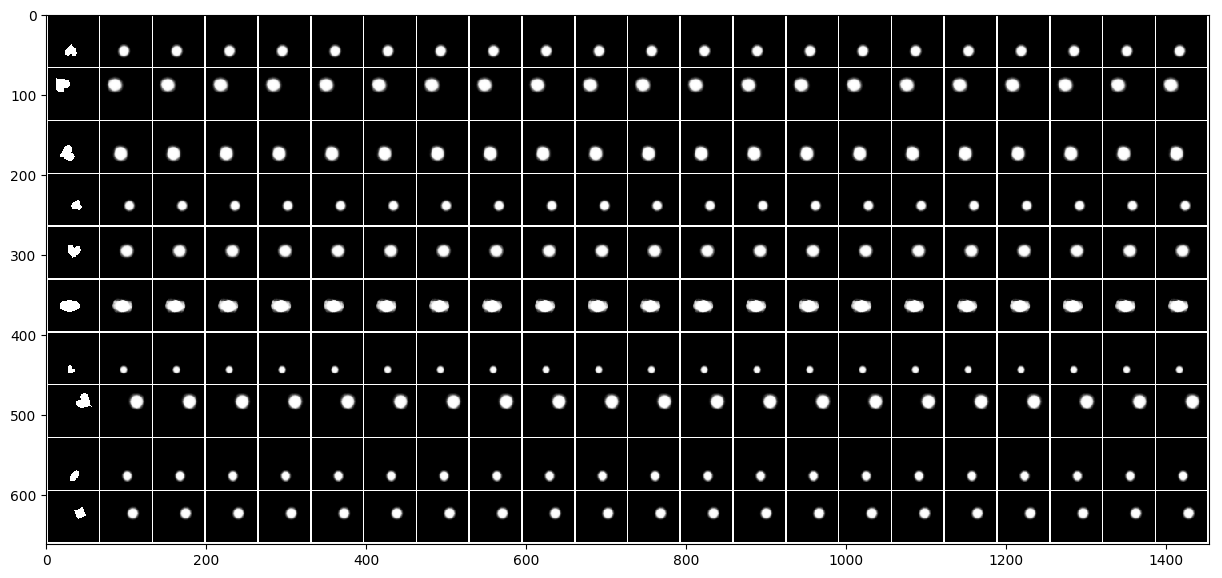

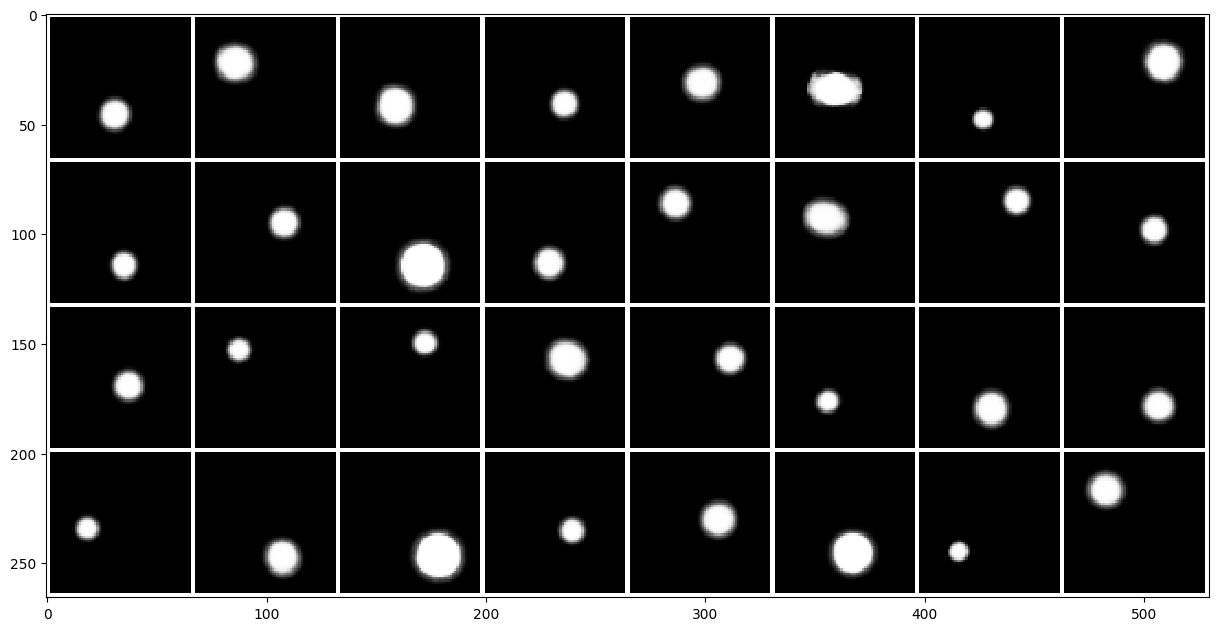

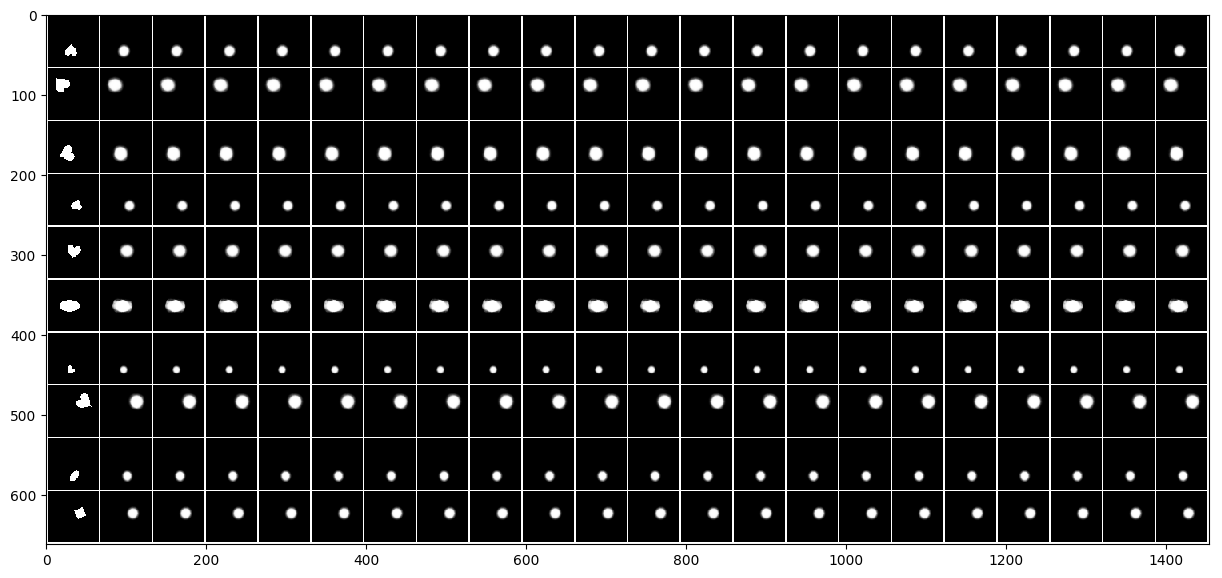

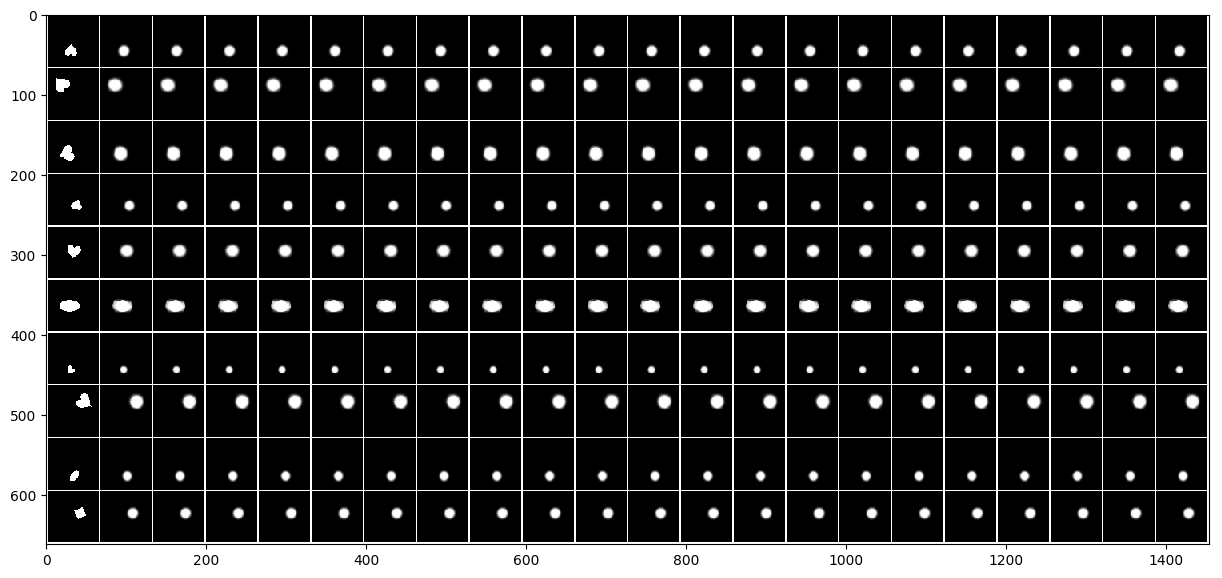

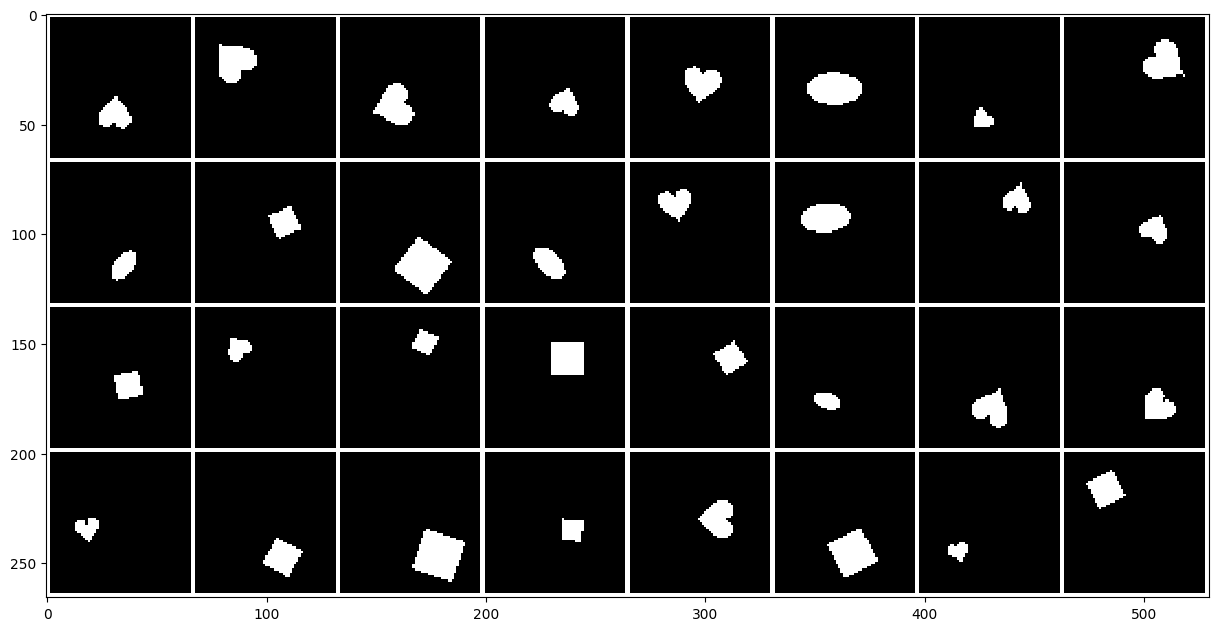

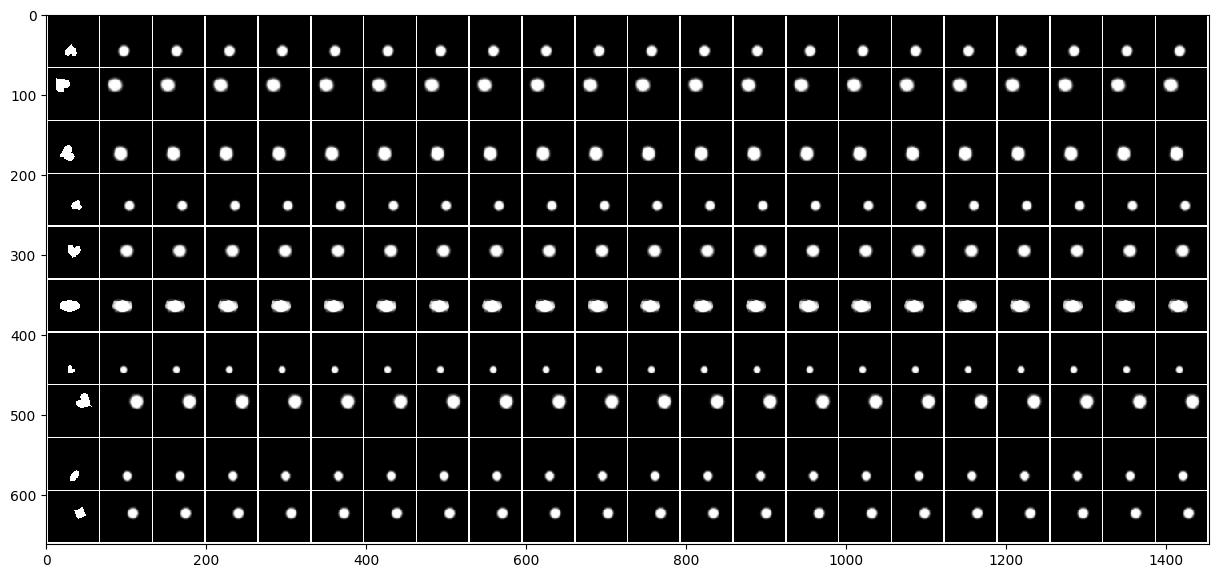

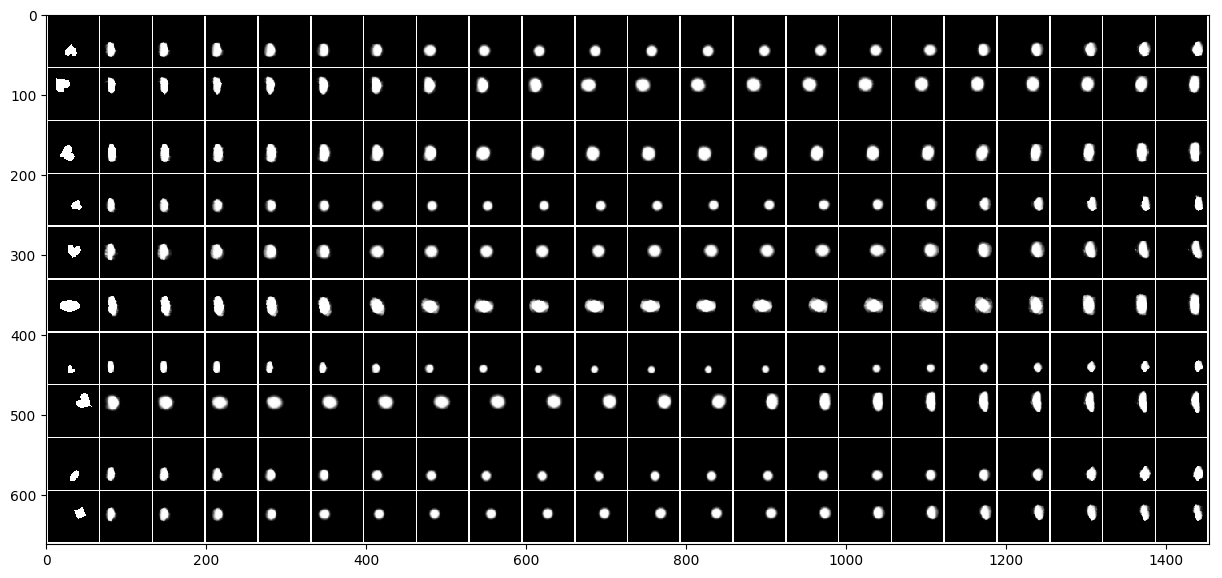

In [0]:
import matplotlib.image as mpimg
from PIL import Image

plt.style.use('default')
for f in glob.glob("{}/*.png".format(output_dir)):
    plt.figure(figsize=(15, 10))
    img=Image.open(f)
    plt.imshow(img)
    plt.show()

In [0]:
with open('/content/gdrive/My Drive/filename.txt', 'w') as f:
    f.write('values')

In [0]:
uploaded = drive.CreateFile({'title': 'filename.csv'})
uploaded.SetContentFile('filename.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

rm: cannot remove '/content/gdrive/My Drive': Is a directory


In [0]:
model_file = drive.CreateFile({'title' : 'model.h5'})
model_file.SetContentFile('model.h5')
model_file.Upload()

'My Drive'


In [0]:
a = torch.randn(3, 3)
print(a)
torch.sum(a, dim=1)

tensor([[-7.0504e-01, -9.7741e-04, -6.7346e-01],
        [-4.8191e-01,  9.0441e-01, -9.4068e-01],
        [-2.1217e-01,  2.2101e-01, -1.6334e+00]])


tensor([-1.3795, -0.5182, -1.6246])

# New Section